# Is tea beneficial for Sanyam's podcast?

How can a single person drink this much tea?

Does Sanyam really prefer tea, or it's just to hide the fact that he might be actually fond of [whiskey](https://twitter.com/abhi1thakur/status/1265660629295271943) mixed-in with tea?

Does drinking tea actually help him with his podcast?

Does he interview his guests differently depending on the tea flavor?

Do his emotions change depending on what he's been drinking? 

Let's answer all of these questions! 

Well, okay, only some of them...

# Approach: Audio Data

Instead of relying on *just* the data provided, I decided to explore Sanyam's youtube videos. My broad goal, indeed, was to correlate his drinking habits to his emotions through his podcast interviews.

While I had plans for 3 separate Kernels around this, thanks to my infinite wisdom around not planning things out, I can only manage this one. And I will be focusing on **Audio data** from CTDS' YouTube videos to predict Sanyam's and the guests' emotions throughout each episode.

# Collecting Audio Data

### CTDS

I couldn't figure out a way to download the audio from any of the podcast sources othter than YouTube. Unfortunately, downloading and converting videos from YouTube to audio (using [youtube-dl](https://github.com/ytdl-org/youtube-dl)) can take quite a bit of time.

I will avoid unnecessary details for now. But you can check out the code I used to download the audio [here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/utils/download_ctds_data.py). 

I also had to clean `Episodes.csv` a little bit for this. Mainly to remove the episodes that start with 'M'. Code for that can be found [here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/utils/clean_data.ipynb). I am also attaching the updated csv for this.

### RAVDESS

To train a model to detect emotions from audio data, I used the audio files from the [RAVDESS](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio) dataset.

I found an extremely helpful [blog post](https://towardsdatascience.com/detecting-emotions-from-voice-clips-f1f7cc5d4827) that utilized the same dataset to carry out model training based on what I wished to try out. The code for downloading and processing the data can be found through that blog post. But I modified and adapted it as well, [here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/utils/modify_ravdess.py).

RAVDESS has 8 emotion categories.

> Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

While I hope some of them are not part of the predictions on Sanyam's episodes, the rest should be suitable for this task.


The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

## Data Preparation

### RAVDESS

I have never worked with audio data before. I had no idea what could be done or what was the SOTA for it or anything. I scrounged github and paperswithcode.com, but... why is everything so overwhelming?!!

[FastAi's book](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb) introduced me to a very interesting approach of converting audio to spectograms and using CNNs for classification. The blog post I shared earlier implemented this exact same approach in the context of emotion detection and I decided to follow that.

It's ridiculous how simple FastAi made this entire process once I had the RAVDESS data downloaded and converted into their corresponding Mel Spectograms.

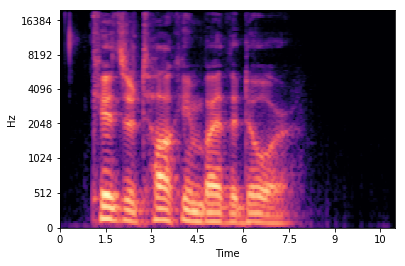


You can tell how happy the person must have been just from the above. I think.

### CTDS

I extracted audio segments from each episode's audio and the converted and saved their respective Mel Spectogram. I used the timestamps from each episode in the `Cleaned Subtitles` data folder. Episode 4's subtitles were missing, and Episode 46's complete audio wasn't available on YouTube either. So, I didn't include them. Episode 12 had the podcast introduction missing, and the timestamps were accordingly mislabeled. I corrected for that as well. 

I am attaching the updated E12 csv as well.

I ignored the first and last audio from each episode. Mainly because those were usually the introduction and closing remarks.

My code to extract the audio clips can be found [here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/utils/extract_audio_segments.py).

Question for anyone who might read this - Do you notice any differences between how I processed RAVDESS audio vs the CTDS audio? The differences might actually help improve the model a little bit.

# Model Training

You can find my approach to train [here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/model_train.ipynb). It's mostly based on the same blog post.

I got an accuracy of ~73%. Which isn't as accurate as I would have preferred, but as a proof-of-concept, I think it's great. And I can work on improving upon it later as well.

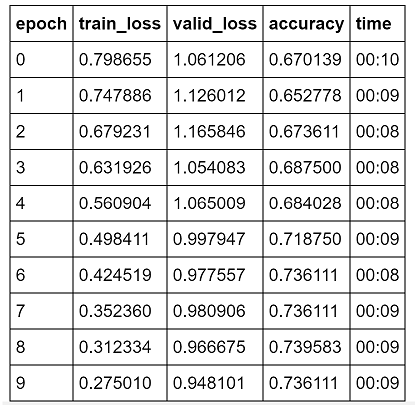

Let's move on to the next session before you notice the validation loss.

# Predictions


After the singificantly time consuming portions of downloading and processing the data, I finally managed to use my trained model and predict on the audio clips' spectograms.

I created a new csv, `predictions.csv`, to store the predictions based on each episode's clips. [Here](https://github.com/sahiljuneja/kaggle-ctds/blob/master/predict.ipynb) is the code for creating this csv. The code, is an effing mess.

In [ ]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', 76)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
# thanks to https://www.kaggle.com/parulpandey/how-to-explore-the-ctds-show-data
!pip install dexplot
!pip install chart_studio
import dexplot as dxp
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

In [ ]:
predictions = pd.read_csv("../input/ctds-audio-emotions/predictions.csv")
predictions = predictions.drop(columns=["Unnamed: 0"])

Here are a few rows from this data.

In [ ]:
predictions.iloc[4803:4808]

There are still some `NaN` values for the predictions. And it is possible I made a mistake somewhere. Hopefully, I can iterate over this.

But, more importantly, why is Sanyam sad during that part of the episode?!

# Emotional Analysis

I'll start by focusing on predictions on Sanyam's clips across all episodes. Just to look at a general count of which was the strongest emotion he likely exhibited.

## Data Cleaning

For simplicity, I am setting all NaN predictions to "Neutral". There are alternatives to this, like I coculd consider dropping the rows altogether, but "Neutral" as an emotion probably works as a good option given the context of an intervivew.

In [ ]:
predictions.info()

The interesting part is that `pred_num` has fewer NaNs than `pred_label`. Which shouldn't be the case. If a `pred_num` exists, there should be a label.

In [ ]:
predictions[~predictions["pred_num"].isnull() & predictions["pred_label"].isnull()].head(5)

The problem is quite clear. During generation of the above dataset, I made a check for if `pred_num` exists or not, and it disregarded the `0.0` values as well.

**NOTE:** The `data_dict` used below does not have the same order as the RAVDESS one. This order is determined based on what the model I trained after re-structuring the dataset into a different format. This can be obtained at time of prediction using `learn.data.classes`.

In [ ]:
data_dict = {0.0: 'angry', 1.0: 'calm', 2.0: 'disgust', 3.0: 'fearful', 4.0: 'happy', 5.0: 'neutral', 6.0: 'sad', 7.0: 'surprised'}

def pred_label(row):
    if row in data_dict:
        return data_dict[row]
    return np.nan
        
predictions["pred_label"] = predictions["pred_num"].apply(pred_label)
predictions[predictions["pred_label"] == "angry"].sample(4)

That's fixed, but at what cost? So much anger...

In [ ]:
predictions.info()

In [ ]:
predictions[predictions["pred_num"].isnull()]["speaker"].value_counts().nlargest(3)

Sanyam has the highest NaN predictions. Setting the values to "Neutral" might create additional bias. 

Also, as I mentioned above, it's surprising to not have a prediction for so many clips. If the clip exists, there should have been a prediction. I believe, this is a result of a fault in my overall pipeline for this project.

In [ ]:
predictions["pred_num_new"] = predictions["pred_num"].fillna(5.0, axis=0)
predictions["pred_label_new"] = predictions["pred_label"].fillna("neutral", axis=0)

In [ ]:
predictions.info()

I will remove Episodes 46 and 4 as well since I didn't have all of the corresponding data for those.

In [ ]:
predictions = predictions[(predictions["episode_num"] != 46) & (predictions["episode_num"] != 4)]
predictions.info()

All right, with enough of the data cleaned, let's jump into some analysis.

## Overall Response

I will start with looking at a general distribution of each predicted emotion for each episode's clips.

In [ ]:
sanyam_emotion = predictions[predictions["speaker"]=="Sanyam Bhutani"].groupby("episode_num")["pred_label"].apply(lambda val: val.value_counts())
color_map = {'angry': 'red', 'calm': 'cyan', 'disgust': 'pink', 'fearful': 'black', 
             'happy': 'orange', 'neutral': 'green', 'sad': 'grey', 'surprised': 'black'}
fig = px.bar(sanyam_emotion.unstack() , color_discrete_map=color_map, title="Count of Predicted Emotions from Sanyam's Audio Clips")
fig.update_xaxes(title_text='Episode Number')
fig.update_yaxes(title_text='Number of Predictions per Emotion')
fig.update_layout(legend_title_text='Emotions')
fig.update_layout(barmode='stack')
fig.show()

Episode 4 and 46 above are blank, and I haven't been able to figure out a simple way to be able to remove them entirely.

Right away we can see that the most prominent emotion is "happy", which is great! I would have been genuinely surprised if it was anything else. My trained model can't be that bad, after all.

Speaking of poorly trained models, thtere is also a fair amount of anger and sadness too. Replacing the NaN values with "neutral" doesn't seem to have made much of an impact. So, that's a good thing for now.

Let's also look at the percentage of each emotion per episode.


In [ ]:
sanyam_emotion = predictions[predictions["speaker"]=="Sanyam Bhutani"].groupby("episode_num")["pred_label"].apply(lambda val: 100*val.value_counts()/val.value_counts().sum())
fig = px.bar(sanyam_emotion.unstack(), color_discrete_map=color_map,  title="Percentage of Predicted Emotions from Sanyam's Audio Clips")
fig.update_xaxes(title_text='Episode Number')
fig.update_yaxes(title_text='Proportion of each Emotion')
fig.update_layout(legend_title_text='Emotions')
fig.update_layout(barmode='stack')
fig.show()

As before, Sanyam's happiness is extremely prominent. That's really great to know, because if I end up on his podcast in a few years, I would love to have a mostly happy host. Episode 74 also shows an interesting outlier, so-to-speak. But based on the previous plot representing the value_counts, Sanyam didn't perhaps speak that much for that episode.

Let's look at some of the actual percentage values corresponding to the "happy" emotion.

In [ ]:
emotion_percent = predictions[predictions["speaker"]=="Sanyam Bhutani"].groupby("episode_num")["pred_label"].apply(lambda val: 100*val.value_counts().nlargest(1)/val.value_counts().sum()).sort_values(ascending=False)

emotion_percent.head(10)

Episode 54, with Sylvain Gugger, he was in pure bliss.

Episode 69 didn't have any guest. It was entirely Sanyam. So, such a high percentage of clips where his emotions were predicted to be "happy" is understandable. 

Episode 67 had multiple guests, so it's possible Sanyam spoke less (also evident from the plots above).

Now, let's bring in the tea.

In [ ]:
episodes = pd.read_csv("../input/ctds-audio-emotions/Episodes_cleaned.csv")


columns_to_use = ["episode_id","flavour_of_tea","recording_time", "episode_duration"]
episodes[columns_to_use].head()

For next aspects of my analysis, I will compare how Sanyam's emotions are predicted depending on different variables (not in any order) - 

- Flavor of tea
- Time of recording
- Change in emotions over an episode's length
- Percentage of highest emotion in relation to the episode's duration
- Percentage of highest emotion in relation to the guest

### Time of Recording

First, let's look at how happy Sanyam is for each episode depending on time of day. I need to modify the dataframe to account for the above categories. I will jmerge the two tables.

In [ ]:
episodes = episodes[columns_to_use]
episodes["episode_num"] = episodes["episode_id"].str[1:].astype(int)
episodes = episodes.drop(columns="episode_id")
pred_merged = predictions.merge(episodes, how="inner", on="episode_num")
pred_merged.head(5)

A general look at when Sanyam recorded his episodes.

In [ ]:
# nlargest is 2 to avoid NaN values for "happy"
happiness_recording_time = pred_merged[pred_merged["speaker"]=="Sanyam Bhutani"].groupby(["episode_num", "recording_time"])["pred_label"].apply(lambda val: 100*val.value_counts().nlargest(2)/val.value_counts().sum())
happiness_recording_time = happiness_recording_time.unstack().reset_index()
fig = px.bar(happiness_recording_time, x="recording_time", title="Number of Episodes per Time of Day")
fig.update_xaxes(title_text='Time of Day')
fig.update_yaxes(title_text='Number of Episodes')
fig.show()

So, most of the episodes are recorded at Night. This is understandable that Sanyam's hosts are mostly from the US, and other countries than India. And that Sanyam does seem to be a night owl.

Let's also look at how happy he is per episode given the time of day. 

**NOTE:** I am currently only focusing on one emotion, "happy", for the sake of simplicity (and limited time). There are only a couple of episodes where "happy" is not the dominant emotion.

In [ ]:
fig = px.scatter(happiness_recording_time, x="recording_time", color="happy",
                 size="happy", hover_data=["happy"],
                 title="Relationship between Time of Day and how happy the host was")
fig.update_xaxes(title_text='Time of Day')
fig.update_yaxes(title_text='Episode Number')
fig.show()

Since the range of the percentage of emotions detected as "happy" is not that wide, it's difficult to distinguish between the sizes. But , it does seem that Sanyam is happier when recording at Night. 

The question really ends up being whether Sanyam is happy because he records at Night, or he records at Night because he feels the most refreshed then on most days.

### Flavor of Tea

Does the flavor of tea influence his mood in any way?

In [ ]:
happiness_tea_flavour = pred_merged[pred_merged["speaker"]=="Sanyam Bhutani"].groupby(["episode_num", "flavour_of_tea"])["pred_label"].apply(lambda val: 100*val.value_counts().nlargest(2)/val.value_counts().sum())
happiness_tea_flavour = happiness_tea_flavour.unstack().reset_index()
happiness_tea_flavour = happiness_tea_flavour[["episode_num", "flavour_of_tea", "happy"]]

By highest percentage of happiness

In [ ]:
happiness_tea_flavour.sort_values(by="happy", ascending=False).head(10)

By lowest percentage of happiness

In [ ]:
happiness_tea_flavour.sort_values(by="happy").head(5)

In [ ]:
fig = px.scatter(happiness_tea_flavour, x="flavour_of_tea", color="happy",
                 size="happy", hover_data=["happy"],
                 title="Relationship between flavour of tea and how happy the host was")
fig.update_xaxes(title_text='Tea Flavour')
fig.update_yaxes(title_text='Episode Number')
fig.show()

It's interesting to see his Tea preferences in batches. Like his streak of Herbal Tea, aand he mostly enjoyed it.

In [ ]:
happiness_tea_flavour.groupby("flavour_of_tea").apply(lambda val: val[val["happy"] > 75.0])["flavour_of_tea"].value_counts().head(3)

Sanyam's mostly happy when he's drinking Ginger Chai and Herbal Tea. But which tea flavour might be his least favorite (less than 75% happiness)?

In [ ]:
happiness_tea_flavour.groupby("flavour_of_tea").apply(lambda val: val[val["happy"] < 75.0])["flavour_of_tea"].value_counts().head(3)

This was evident from the plot above as well, but it seems Masala Chai doesn't lift up Sanyam's spirits much.

Ginger isn't far behind. So, as it turns out, Sanyam's pretty torn on Ginger by the looks of it. Maybe looking at the time of recording and the flavour of tea in the future might give a better understanding too.

### Change in Emotions Over an Episode's Length

I have mostly looked at how happy Sanyam seemed to be. Let's now look at how the perceived (predicted) emotions changed as the episode progressed.

In [ ]:
pred_merged_sanyam = pred_merged[(pred_merged["speaker"]=="Sanyam Bhutani")]


fig = px.scatter(pred_merged_sanyam, x="episode_clip", y="pred_label_new", color="pred_label_new", color_discrete_map=color_map,
                 title="Emotional Journey through an Episode", labels={"pred_label_new": "Prediction Label"},
               animation_frame='episode_num')
fig.update_xaxes(title_text='Episode Clips')
fig.update_yaxes(title_text='Prediction Label')
# https://community.plotly.com/t/how-to-slow-down-animation-in-plotly-express/31309/6
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()
# emotion_episode_clip


I haven't been able to figure out how to dynamically adjust the x-axis for each episode/frame. But the above gives an idea of how Sanyam's emotions, predicted as per his audio clips, change during the episode.

Because of replacing NaNs with "neutral", we can see them to occur more frequently. 

Episode 12 and Episode 7 were probably not Sanyam's best given how sad and angry he got.

### Happiness in relation to episode duration

In [ ]:
happiness_episode_duration = pred_merged[pred_merged["speaker"]=="Sanyam Bhutani"].groupby(["episode_num", "episode_duration"]).apply(lambda val: 100*val["pred_label"].value_counts().nlargest(2)/val["pred_label"].value_counts().sum())
happiness_episode_duration = happiness_episode_duration.unstack().reset_index()
happiness_episode_duration = happiness_episode_duration[["episode_num", "episode_duration", "happy"]]
fig = px.scatter(happiness_episode_duration, x="episode_num",y="episode_duration", color="happy",
                 size="episode_duration", hover_data=["happy", "episode_duration"],
                 title="Relationship between episode duration and how happy the host was")
fig.update_xaxes(title_text='Episode Number')
fig.update_yaxes(title_text='Episode Duration')
fig.show()

In [ ]:
happiness_episode_duration.sort_values(by=["happy"], ascending=False).head(5)

It does seem that Sanyam has a slight preference towards average sized episodes. But there isn't any concrete trend. He does seem to have gotten happier as he created more and more episodes though.

# Conclusion (for now)

This was my attempt to challenge myself with a project that pushes me outside of my comfort zone where I piece things together to come up with an analysis. Purely as an attempt to learn more. Predicting emotions using audio was a fun way to approach this. And there's still a LOT to analyze as well. 

## Future Work

There is no shortage of what can be done here -

- Explore more variables in relation to other predicted emotions
- Explore emotions of Guests with the same variables
- Incorporate transcripts for comparison with audio
- Improve emotion detection model
- Fix issues
- etc.

I included `predictions.csv` so that others could try things out. Downloading the audio data can be time consuming, but I could provide the spectogram images from the data if someone would like to play around with it.

## Possible Biases

RAVDESS dataset contains neutral North-American accents. While they had an equal number of male and female [voice] actors record the data, there is still a lingering question of diversity. 

Sanyam and his guests do cover a broader range than just "neutral North-American" accents. Plus, as other Kernels pointed out, the podcast, in its current form, is heavily skewed towards male guests. Also, the category of emotions used is quite basic as well. This ofcourse might bring up some biases during predictions. I haven't yet analyzed the data from that perspective. 
